# Applied Machine Learning: In-class Exercise 01-4

## Goal
In this exercise, we will build a machine learning model using Python and scikit-learn to predict credit risk—that is, the probability of an individual being classified as a good or bad credit applicant for a bank. Our objective is not to create the most optimal classifier but to understand and analyze the model’s predictions.

We will focus on evaluating model performance using key metrics such as sensitivity (True Positive Rate, TPR) and specificity (which is equal to 1 - False Positive Rate, FPR). Additionally, we will explore how adjusting the decision threshold affects classification outcomes, leading to different prediction results.

To visualize and interpret these trade-offs, we will generate a ROC curve using scikit-learn and discuss its properties. This will help us analyze the impact of threshold adjustments on model performance.

## 1 Train a classification tree on the german credit task

First, we load the predefined German credit dataset from OpenML and set the positive class to "good". We then preprocess the data by one-hot encoding categorical variables and splitting it into training (2/3) and test (1/3) sets, ensuring stratification based on the target variable.

Next, we train a Random Forest classifier using scikit-learn on the training set. Once trained, we generate probabilistic predictions on the test set, obtaining the predicted probabilities for both the "good" and "bad" credit classes.

<details>
<summary>Hint 1:</summary>
Remember to encode the cagegorical features.
</details>

<details>
<summary>Hint 2:</summary>
Use `RandomForestClassifier` from scikit-learn.
</details>

In [1]:
#===SOLUTION===
import numpy as np
import pandas as pd

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings("ignore")


X, y = fetch_openml("credit-g", version=1, as_frame=True, return_X_y=True)

X_encoded = pd.get_dummies(X, drop_first=True)

# Create a train-test split: 2/3 training, 1/3 testing.
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=1/3, random_state=42
)
print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

# Train a Random Forest classifier that outputs probabilities.
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Make predictions on the test set.
pred_labels = clf.predict(X_test)
probs = clf.predict_proba(X_test)

Training set size: 666
Test set size: 334


## 2. Confusion Matrices

We will inspect and save the confusion matrix for the predictions made in the previous step. Using the confusion matrix, we will manually compute the False Positive Rate (FPR) and True Positive Rate (TPR) based on the formula:

* True Positive Rate (TPR) = True Positives / (True Positives + False Negatives)

* False Positive Rate (FPR) = False Positives / (False Positives + True Negatives)

Instead of manually computing these metrics, we can also use scikit-learn’s built-in functions, such as recall_score (which directly computes TPR) and roc_curve (which provides FPR and TPR across various thresholds).

<details>
<summary>Recap</summary>
A confusion matrix is a table used to summarize model performance by comparing actual vs. predicted class labels. It helps in understanding how well the classifier distinguishes between "good" and "bad" credit applicants.
Binary classifiers typically first generate a score (often a probability) and then apply a threshold ($t$) to decide class membership:

Instances with a score $ \geq t$ are classified as positive ("good")

Instances with a score $< 𝑡$ are classified as negative ("bad")

By adjusting this threshold, we can obtain different classification results and analyze the trade-off between false positives and false negatives. This trade-off can be visualized using ROC curves, which we will explore next.

</details>

<details>
<summary>Hint 1:</summary>
Use `sklearn.metrics.confusion_matrix` from scikit-learn to compute the confusion matrix.
</details>

<details>
<summary>Hint 2:</summary>
Manually compute the TPR and FPR using the values in the confusion matrix.
</details>

<details>
<summary>Hint 3:</summary>
Alternatively, use `sklearn.metrics.recall_score` from scikit-learn to compute TPR.
</details>


In [2]:
#===SOLUTION===

from sklearn.metrics import confusion_matrix, recall_score


# Make sure that probabilities for "good" and "bad" are correctly assigned.
classes = clf.classes_
prob_good = probs[:, list(classes).index("good")]
prob_bad = probs[:, list(classes).index("bad")]

results = pd.DataFrame({
    "row_ids": X_test.index,
    "truth": y_test,
    "response": pred_labels,
    "prob.good": prob_good,
    "prob.bad": prob_bad
})
print(f"Prediction results (first 5 rows):\n{results.head()}")

# Compute the confusion matrix.
# Set labels to ensure the order is: "good" then "bad".
cm = confusion_matrix(y_test, pred_labels, labels=["good", "bad"])
# The structure is:
#       predicted: good   bad
# true: good      TP        FN
#       bad       FP        TN
print(f"Confusion Matrix (rows: true labels, columns: predicted labels):\n{cm}")

# Manually compute TPR (sensitivity) and FPR.
TPR = cm[0, 0] / cm[0, :].sum()
FPR = cm[1, 0] / cm[1, :].sum()
print(f"Manual computation: TPR: {TPR:.4f}; FPR: {FPR:.4f}")

# Alternatively, compute TPR using scikit-learn's recall_score (recall equals sensitivity).
TPR_alternative = recall_score(y_test, pred_labels, pos_label="good")
print(f"TPR (sklearn): {TPR_alternative:.4f}")

Prediction results (first 5 rows):
     row_ids truth response  prob.good  prob.bad
521      521   bad     good       0.62      0.38
737      737  good      bad       0.43      0.57
740      740  good      bad       0.45      0.55
660      660  good     good       0.58      0.42
411      411  good     good       0.94      0.06
Confusion Matrix (rows: true labels, columns: predicted labels):
[[215  17]
 [ 65  37]]
Manual computation: TPR: 0.9267; FPR: 0.6373
TPR (sklearn): 0.9267


## 3 Asymmetric costs

In some scenarios, misclassifying a positive instance ("good" credit applicant) as negative has different consequences than misclassifying a negative instance ("bad" credit applicant) as positive.

For this task, consider which type of error is more costly for a bank:
False Negatives (FN): A "good" applicant is incorrectly classified as "bad," potentially denying credit to a trustworthy customer.
False Positives (FP): A "bad" applicant is incorrectly classified as "good," increasing the risk of financial loss for the bank.

To adjust for asymmetric costs, we modify the classification threshold used for decision-making without retraining the model. Instead of using the default 0.5 threshold, we experiment with a higher threshold (e.g., 0.7) to reduce the number of False Positives (FP)—that is, fewer "bad" applicants being classified as "good."

After adjusting the threshold, we compute new predictions and compare them with the previous results:
1. Compute the new confusion matrix

2. Recalculate False Positive Rate (FPR) and True Positive Rate (TPR)

3. Compare these values with those from the previous threshold

By adjusting the threshold, we can trade off sensitivity (TPR) for specificity (1 - FPR) depending on the bank’s risk tolerance.

<details>
<summary>Hint 1:</summary>
Wrap the previous classifier in `sklearn.model_selection.FixedThresholdClassifier` to create another classifier with different classification threshold.
</details>


In [3]:
#===SOLUTION===

from sklearn.model_selection import FixedThresholdClassifier


# Using the model's default predictions (already computed earlier)
cm1 = confusion_matrix(y_test, pred_labels, labels=["good", "bad"])
TPR1 = cm1[0, 0] / cm1[0, :].sum()
FPR1 = cm1[1, 0] / cm1[1, :].sum()
print("Default Threshold 0.5, Confusion Matrix:\n", cm1)
print(f"TPR1: {TPR1:.4f}")
print(f"FPR1: {FPR1:.4f}")


# Set a higher threshold to reduce false positives
# Create a fixed threshold classifier that wraps the original model
# We need to provide the probabilities and the threshold
fixed_threshold_clf = FixedThresholdClassifier(
    estimator=clf,
    threshold=0.7,
    pos_label="good"
)

# Get predictions using the fixed threshold classifier
pred_labels_thresh = fixed_threshold_clf.predict(X_test)

# Compute the confusion matrix for the new predictions.
cm2 = confusion_matrix(y_test, pred_labels_thresh, labels=["good", "bad"])
TPR2 = cm2[0, 0] / cm2[0, :].sum()
FPR2 = cm2[1, 0] / cm2[1, :].sum()

print("\nNew Threshold 0.7, Confusion Matrix:\n", cm2)
print(f"TPR2: {TPR2:.4f}")
print(f"FPR2: {FPR2:.4f}")

print("\nDifferences compared to default threshold:")
print(f"TPR2 - TPR1 = {(TPR2 - TPR1):.4f}")
print(f"FPR2 - FPR1 = {(FPR2 - FPR1):.4f}")

Default Threshold 0.5, Confusion Matrix:
 [[215  17]
 [ 65  37]]
TPR1: 0.9267
FPR1: 0.6373

New Threshold 0.7, Confusion Matrix:
 [[157  75]
 [ 27  75]]
TPR2: 0.6767
FPR2: 0.2647

Differences compared to default threshold:
TPR2 - TPR1 = -0.2500
FPR2 - FPR1 = -0.3725


## 4 ROC Curve

In the previous exercises, we calculated the False Positive Rate (FPR) and True Positive Rate (TPR) for two specific thresholds. Now, we extend this analysis by computing these values across all possible thresholds to visualize the Receiver Operating Characteristic (ROC) curve.
The ROC curve is a graphical representation of a classifier’s performance across different decision thresholds. It plots:

TPR (Sensitivity) on the Y-axis

FPR (1 - Specificity) on the X-axis

To generate the ROC curve in Python, we use roc_curve from scikit-learn, which computes FPR and TPR at various threshold levels. We then visualize the curve, along with the diagonal reference line (random classifier), to analyze the model’s ability to distinguish between "good" and "bad" credit applicants.

The Area Under the Curve (AUC) is also computed to summarize the classifier’s overall performance—the closer AUC is to 1.0, the better the model is at classification.

<details>
<summary>Hint 1:</summary>
Use `sklearn.metrics.RocCurveDisplay` along with `matplotlib` to visualize the ROC curve.
</details>


<Figure size 800x600 with 0 Axes>

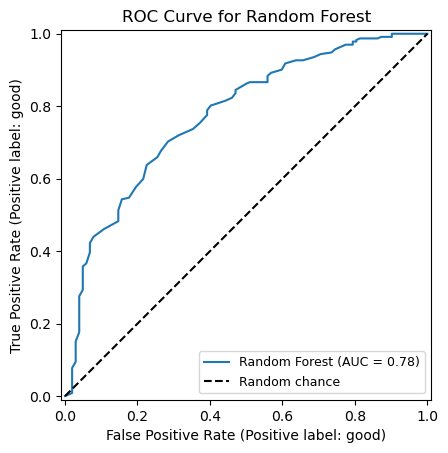

In [4]:
#===SOLUTION===

import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

# Create and plot the ROC curve display for the "good" class
plt.figure(figsize=(8, 6))
RocCurveDisplay.from_predictions(
    y_test, 
    prob_good,
    pos_label="good",
    name="Random Forest"
)

# Add the random chance line
plt.plot([0, 1], [0, 1], 'k--', label='Random chance')
plt.title('ROC Curve for Random Forest')
plt.legend(loc="lower right", fontsize=9)
plt.show()

## 5 ROC Comparison & 6 Area Under the Curve

In this exercise, we will explore how to compare two learners by looking at their ROC curves. Unlike the R version, here we merge the section 5 and 6 into a single exercise, because the ROC curve and the AUROC can be computed in a single for-loop over the models.

The basis for this exercise will be a benchmark experiment that compares a Decision Tree with a Random Forest on the German credit task.

Because we are now not only focused on analyzing a given prediction but also on comparing two learners, we use 10-fold cross-validation to reduce the uncertainty of this comparison.

Conduct the benchmark experiment and plot both ROC curves in a single graph. Which learner performs better in this case?

<details>
<summary>Hint 1:</summary>
Use `StratifiedKFold` to define a 10-fold cross-validation.
</details>

<details>
<summary>Hint 2:</summary>
Train both learners (Decision Tree and Random Forest) on each fold and compute the ROC curve for each fold.
</details>

<details>
<summary>Hint 3:</summary>
Interpolate the True Positive Rate (TPR) values at common False Positive Rate (FPR) points to obtain a smooth ROC curve.
</details>

<details>
<summary>Hint 4:</summary>
Compute the mean and standard deviation of TPR across folds and plot the mean ROC curve with shaded ±1 standard deviation.
</details>

<details>
<summary>Hint 5:</summary>
Plot a boxplot of the AUC values for each learner.
</details>


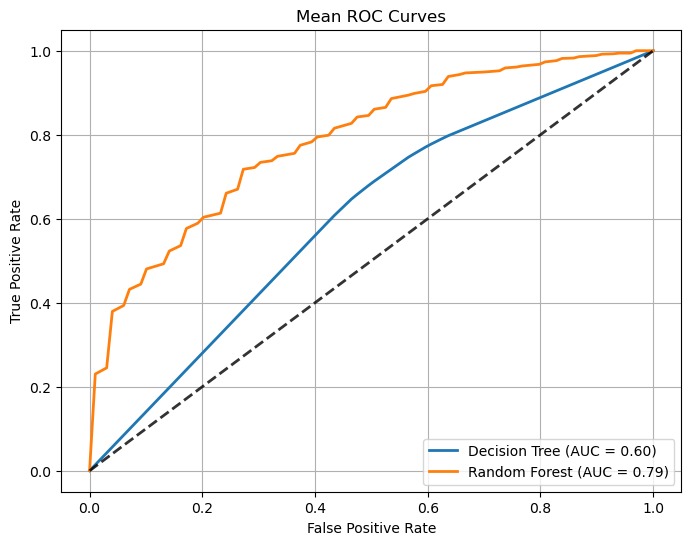

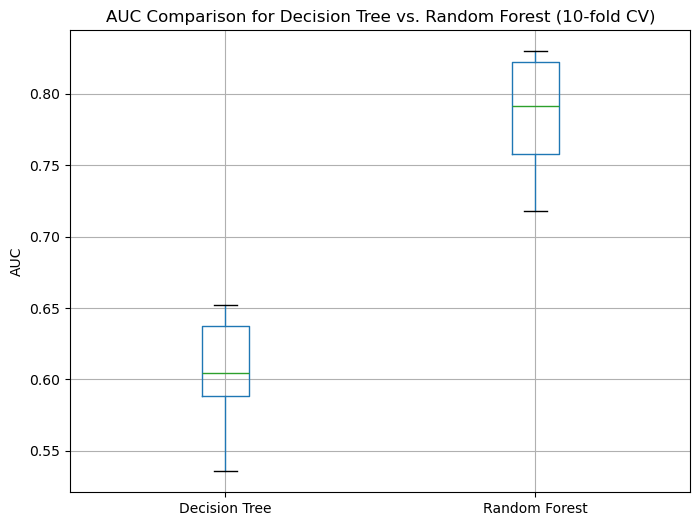

Decision Tree: Mean AUC = 0.60 ± 0.04
Random Forest: Mean AUC = 0.79 ± 0.04


In [5]:
#===SOLUTION===

from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc


# Define 10-fold cross-validation and the two learners
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
learners = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42)
}

# Dictionaries to store AUC values for each learner.
auc_results = {}

# Create a ROC plot with mean ROC curves
plt.figure(figsize=(8, 6))
for name, model in learners.items():
    tprs = []   # To store interpolated TPRs for each fold
    aucs = []   # To store AUC values for each fold
    mean_fpr = np.linspace(0, 1, 100)  # Common FPR points for interpolation

    # Cross-validation loop.
    for train_idx, test_idx in cv.split(X_encoded, y):
        X_train_cv = X_encoded.iloc[train_idx]
        y_train_cv = y.iloc[train_idx]
        X_test_cv = X_encoded.iloc[test_idx]
        y_test_cv = y.iloc[test_idx]

        model.fit(X_train_cv, y_train_cv)
        # Get probabilities for the "good" class.
        probas = model.predict_proba(X_test_cv)
        pos_index = list(model.classes_).index("good")
        probas_good = probas[:, pos_index]

        # Compute ROC for this fold.
        fpr, tpr, _ = roc_curve(y_test_cv, probas_good, pos_label="good")
        # Interpolate TPR values at the common FPR points.
        tpr_interp = np.interp(mean_fpr, fpr, tpr)
        tpr_interp[0] = 0.0
        tprs.append(tpr_interp)
        fold_auc = auc(fpr, tpr)
        aucs.append(fold_auc)

    # Compute mean TPR and AUC across folds.
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    std_tpr = np.std(tprs, axis=0)
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    auc_results[name] = aucs  # Save the fold AUCs for later boxplot

    # Plot the mean ROC curve
    plt.plot(mean_fpr, mean_tpr, lw=2,
             label=f"{name} (AUC = {mean_auc:.2f})")

# Plot the diagonal chance line.
plt.plot([0, 1], [0, 1], linestyle="--", lw=2, color="black", alpha=0.8)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Mean ROC Curves")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Create a DataFrame from the AUC results and display summary statistics.
auc_df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in auc_results.items()]))
# Plot a boxplot of the AUC values for each learner.
plt.figure(figsize=(8, 6))
auc_df.boxplot()
plt.ylabel("AUC")
plt.title("AUC Comparison for Decision Tree vs. Random Forest (10-fold CV)")
plt.show()

for name, auc_list in auc_results.items():
    mean_auc = np.mean(auc_list)
    std_auc = np.std(auc_list)
    print(f"{name}: Mean AUC = {mean_auc:.2f} ± {std_auc:.2f}")

## 7 Threshold plot

Another useful way to analyze the performance of a classifier is to visualize how a performance metric changes across varying thresholds. In this case, we will examine the True Positive Rate (TPR) and False Positive Rate (FPR) over all possible thresholds.
Compare the TPR and FPR across different thresholds for the Random Forest prediction object from the first exercise. Identify the threshold at which TPR is optimal while ensuring that FPR does not exceed 50%.


<details>
<summary>Hint 1:</summary>
For each threshold, predict "good" if the probability is greater than or equal to the threshold, and "bad" otherwise.
</details>

<details>
<summary>Hint 2:</summary>
Compute the confusion matrix for each threshold and calculate TPR and FPR.
</details>

<details>
<summary>Hint 3:</summary>
Identify the threshold at which TPR is highest while FPR is at most 50%.
</details>



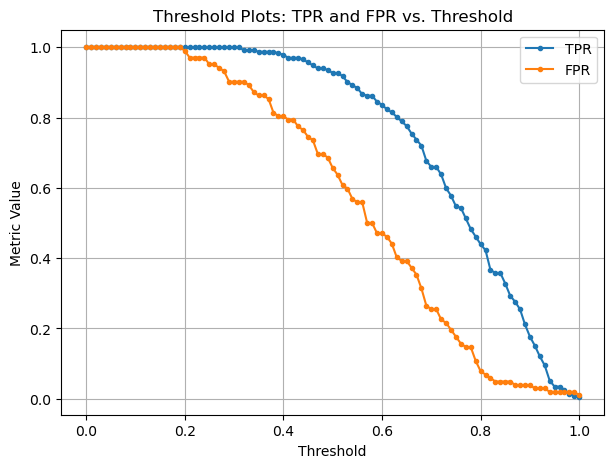

Best threshold: 0.57 with TPR: 0.86 and FPR: 0.50


In [6]:
#===SOLUTION===

thresholds = np.linspace(0, 1, 101)
TPR_list = []
FPR_list = []

for t in thresholds:
    # For each threshold, predict "good" if probability >= t, else "bad"
    pred_labels_t = np.where(prob_good >= t, "good", "bad")

    # Compute the confusion matrix using a fixed label order: ["good", "bad"]
    cm_t = confusion_matrix(y_test, pred_labels_t, labels=["good", "bad"])
    # cm_t structure:
    #           Predicted: good    bad
    # True: good     TP         FN
    #       bad      FP         TN

    TP = cm_t[0, 0]
    FN = cm_t[0, 1]
    FP = cm_t[1, 0]
    TN = cm_t[1, 1]

    # Calculate TPR and FPR. Avoid division by zero.
    TPR_value = TP / (TP + FN) if (TP + FN) > 0 else 0
    FPR_value = FP / (FP + TN) if (FP + TN) > 0 else 0

    TPR_list.append(TPR_value)
    FPR_list.append(FPR_value)

# Plot the TPR and FPR as a function of the threshold.
plt.figure(figsize=(7, 5))
plt.plot(thresholds, TPR_list, label="TPR", marker='o', markersize=3)
plt.plot(thresholds, FPR_list, label="FPR", marker='o', markersize=3)
plt.xlabel("Threshold")
plt.ylabel("Metric Value")
plt.title("Threshold Plots: TPR and FPR vs. Threshold")
plt.legend()
plt.grid(True)
plt.show()

# Identify the threshold at which TPR is highest while FPR is at most 50%.
thresholds_array = np.array(thresholds)
TPR_array = np.array(TPR_list)
FPR_array = np.array(FPR_list)

# Find indices where FPR is at most 0.5
valid_indices = np.where(FPR_array <= 0.5)[0]

if valid_indices.size > 0:
    # Among these, find the index with maximum TPR.
    best_idx = valid_indices[np.argmax(TPR_array[valid_indices])]
    best_threshold = thresholds_array[best_idx]
    best_TPR = TPR_array[best_idx]
    best_FPR = FPR_array[best_idx]
    print(f"Best threshold: {best_threshold:.2f} with TPR: {best_TPR:.2f} and FPR: {best_FPR:.2f}")
else:
    print("No threshold found with FPR at or below 50%.")


## 8 Precision-Recall curves

We can also analyze model performance by interpreting precision and recall together.
Precision quantifies the proportion of predicted positives that are actually positive.
Recall (also known as True Positive Rate, TPR) measures the proportion of actual positives correctly identified.

A precision-recall curve plots precision and recall across all possible thresholds. In situations where class frequencies are highly imbalanced, the ROC curve may be misleading, making the precision-recall curve a more useful evaluation tool.
Plot the precision-recall curves for the two learners (Decision Tree and Random Forest) that we evaluated in the benchmark experiment.


<details>
<summary>Hint 1:</summary>
Use `precision_recall_curve` and `average_precision_score` from scikit-learn to compute the precision-recall curve and average precision.
</details>

<details>
<summary>Hint 2:</summary>
Interpolate precision values at common recall points to obtain a smooth curve.
</details>

<details>
<summary>Hint 3:</summary>
Compute the mean and standard deviation of precision across folds and plot the mean precision-recall curve with shaded ±1 standard deviation.
</details>


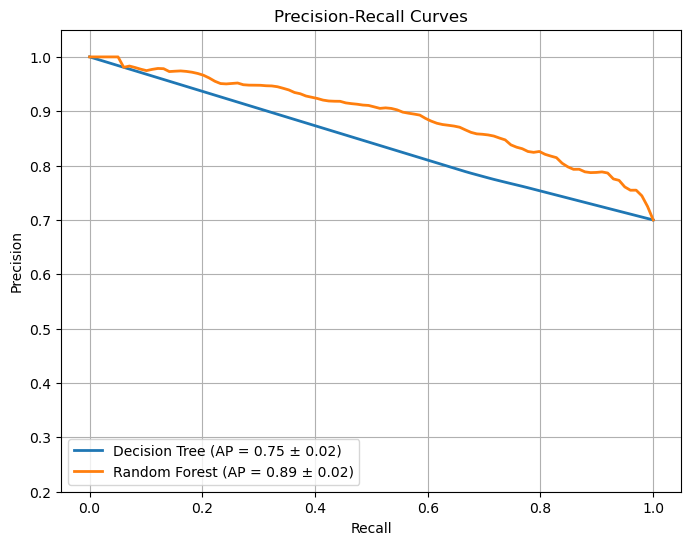

In [7]:
from sklearn.metrics import precision_recall_curve, average_precision_score

plt.figure(figsize=(8, 6))

# Use the same cv and learners from previous cells
for name, model in learners.items():
    # To store interpolated precision values for each fold
    precision_interp_list = []  
    # Common recall points for interpolation
    recall_grid = np.linspace(0, 1, 100)  
    # Average precision scores for each fold
    ap_scores = []  

    # 10-fold cross-validation loop.
    for train_idx, test_idx in cv.split(X_encoded, y):
        X_train_cv = X_encoded.iloc[train_idx]
        y_train_cv = y.iloc[train_idx]
        X_test_cv = X_encoded.iloc[test_idx]
        y_test_cv = y.iloc[test_idx]

        model.fit(X_train_cv, y_train_cv)
        # Get probabilities for the positive class "good"
        probas = model.predict_proba(X_test_cv)
        pos_index = list(model.classes_).index("good")
        probas_good = probas[:, pos_index]

        # Compute precision-recall curve for this fold.
        precision, recall, _ = precision_recall_curve(y_test_cv, probas_good, pos_label="good")
        # Note: precision_recall_curve returns arrays with recall in descending order.
        # Reverse them so that recall is increasing.
        precision = precision[::-1]
        recall = recall[::-1]

        # Interpolate precision at the common recall grid points.
        precision_interp = np.interp(recall_grid, recall, precision)
        precision_interp_list.append(precision_interp)

        # Also compute the average precision score for this fold.
        # For binary classification, average_precision_score expects binary labels.
        ap = average_precision_score((y_test_cv == "good").astype(int), probas_good)
        ap_scores.append(ap)

    # Compute the mean precision across folds.
    mean_precision = np.mean(precision_interp_list, axis=0)
    mean_ap = np.mean(ap_scores)
    std_ap = np.std(ap_scores)

    # Plot the mean Precision-Recall curve.
    plt.plot(recall_grid, mean_precision, lw=2,
             label=f"{name} (AP = {mean_ap:.2f} ± {std_ap:.2f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.ylim([0.2, 1.05])
plt.title("Precision-Recall Curves")
plt.legend(loc="lower left")
plt.grid(True)
plt.show()


Question: Discuss the plot that you obtained.

===SOLUTION===

Similar to the ROC Curve, the random forest model outperforms the decision tree model in terms of precision-recall curves. For a given recall rate, it achieves higher precision.

## Summary

In this exercise we improved our understanding of the performance of binary classifiers by the means of the confusion matrix and a focus on different error types. We have seen how we can analyze and compare classifiers using the ROC and AUC.